In [1]:
from scipy.special import i0, k0

# Physical constants
from scipy.constants import e, h, k as k_B, pi
J_per_eV = e
BCS = 1.76

# Aluminum
N0_per_um3_per_eV = 1.72e10
tau_0 = 438e-9  # From Kaplan; one also sees 100 ns in more recent work; verify.

In [2]:
# Device-dependent constants

# Critical temperature, in K
T_c = 0.8

# Phonon-trapping factor
F_omega = 2 #10

# Geometry, in microns
L_um = 2000
W_um = 8
T_um = 0.1
V_um3 = L_um * W_um * T_um
print("V_active = {:.0f} um^3".format(V_um3))

# Kinetic inductance fraction, taken from Sonnet
alpha = 0.25

# Resonance frequency, in Hz
f_r = 3e9

# Inverse coupling quality factor
iQc = 30e-6
print("Q_c = {}".format(1 / iQc))

# Limiting internal Q_i due to non-quasiparticle loss
iQi0 = 1e-6

# TLS spectral density at 1 Hz and reference internal power P_i_TLS, in W
S_TLS = 1e-19
P_i_TLS = 1e-13  # -100 dBm

V_active = 1600 um^3
Q_c = 33333.3333333


In [3]:
# Optical system and environment

# Optical bandwidth, in Hz
bandwidth = (170 - 130) * 1e9

# Background absorbed power, in W
P_B = 1e-18

# System optical efficiency (not implemented yet)
#eta = 1

# Bath temperature, in K
T_bath = 0.1

In [4]:
# Readout parameters

# Amplifier noise temperature, in K
T_amp = 4

In [5]:
def gap_frequency(T_c):
    return 2 * BCS * k_B * T_c / h
    
def pair_breaking_efficiency(nu, T_c):
    nu_g = gap_frequency(T_c)
    eta_pb = nu_g / nu
    eta_pb[nu < nu_g] = 0
    eta_pb[2 * nu_g < nu] = 1 / 2
    return eta_pb

def quasiparticles_per_photon(nu, T_c):
    return 2 * pair_breaking_efficiency(nu, T_c) * nu / gap_frequency(T_c)

def S_1(f, T, T_c):
    Delta = BCS * k_B * T_c
    xi = h * f / (2 * k_B * T)
    return 2 / pi * (2 * Delta / (pi * k_B * T))**(1/2) * np.sinh(xi) * k0(xi)

def S_2(f, T, T_c):
    Delta = BCS * k_B * T_c
    xi = h * f / (2 * k_B * T)
    return 1 + (2 * Delta / (pi * k_B * T))**(1/2) * np.exp(-xi) * i0(xi)

def iQqp(f, T, T_c, V_um3, Gamma, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (2 * alpha * S_1(f, T, T_c) * N_qp(Gamma=Gamma, V_um3=V_um3) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def x(f, T, T_c, V_um3, Gamma, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (alpha * S_2(f, T, T_c) * N_qp(Gamma=Gamma, V_um3=V_um3) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def tau_qp(Gamma, V_um3):
    return N_qp(Gamma=Gamma, V_um3=V_um3) / (2 * Gamma)

def N_qp(Gamma, V_um3):
    return (V_um3 * Gamma / R_star_um3_per_s)**(1/2)

def chi_c(iQi, iQc):
    return 4 * iQi * iQc * (iQi + iQc)**-2

def chi_g(iQi, iQc, x):
    return (1 + (2 * x / (iQi + iQc))**2)**-1

# The default assumes that we can always tune on-resonance.
def chi_a(iQi, iQc, x=0):
    return 1 / 2 * chi_c(iQi=iQi, iQc=iQc) * chi_g(iQi=iQi, iQc=iQc, x=x)

In [6]:
# Derived constants
print("\\Delta = {:.0f} ueV".format(1e6 * BCS * k_B * T_c / J_per_eV))

# Gap frequency
print("\\nu_g = {:.1f} GHz".format(1e-9 * gap_frequency(T_c)))

# Recombination constant
R_um3_per_s = (2 * BCS)**3 / (4 * N0_per_um3_per_eV * (BCS * k_B * T_c / J_per_eV) * tau_0)
print("R = {:.1f} um^3 s^-1".format(R_um3_per_s))

# Effective recombination constant
R_star_um3_per_s = R_um3_per_s / F_omega
print("R_* = {:.1f} um^3 s^-1".format(R_star_um3_per_s))

\Delta = 121 ueV
\nu_g = 58.7 GHz
R = 11.9 um^3 s^-1
R_* = 6.0 um^3 s^-1


For "frequency readout," the full response chain is
\begin{equation*}
\frac{\mathrm{d} S_{21}}{\mathrm{d} P_A}
  =
  \frac{\mathrm{d} S_{21}}{\mathrm{d} x}
  \frac{\mathrm{d} x}{\mathrm{d} Z_s}
  \frac{\mathrm{d} Z_s}{\mathrm{d} \sigma}
  \frac{\mathrm{d} \sigma}{\mathrm{d} N_{qp}}
  \frac{\mathrm{d} N_{qp}}{\mathrm{d} \Gamma_A}
  \frac{\mathrm{d} \Gamma_A}{\mathrm{d} P_A}.
\end{equation*}

In [7]:
# Responsivities
def d_Gamma_A_d_P_A(nu, T_c):
    if isinstance(nu, (np.ndarray, list, tuple)):
        m = quasiparticles_per_photon(nu=nu, T_c=T_c)
    else:
        m = quasiparticles_per_photon(nu=np.array([nu]), T_c=T_c)[0]
    return m / (h * nu)

def d_N_qp_d_Gamma_A(Gamma, V_um3):
    return tau_qp(Gamma=Gamma, V_um3=V_um3)

def d_iQi_d_N_qp(f, T, T_c, V_um3, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (2 * alpha * S_1(f=f, T=T, T_c=T_c) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def d_x_d_N_qp(f, T, T_c, V_um3, alpha):
    Delta_eV = BCS * k_B * T_c / J_per_eV
    return (alpha * S_2(f=f, T=T, T_c=T_c) /
            (4 * N0_per_um3_per_eV * Delta_eV * V_um3))

def d_S21_d_iQi(iQi, iQc):
    return chi_c(iQi=iQi, iQc=iQc) / (4 * iQi)

def d_S21_d_x(iQi, iQc):
    return 1j * chi_c(iQi=iQi, iQc=iQc) / (2 * iQi)

# NEP

For a given absorbed power $P_A$, calculate 

In [8]:
def NEP2_photon_simple(P_A, P_B, nu, bandwidth):
    return 2 * h * nu * (P_A + P_B) + 2 * P_A**2 / bandwidth


def NEP2_photon(Gamma_A, Gamma_B, nu, T_c, bandwidth):
    m = quasiparticles_per_photon(nu=np.array([nu]), T_c=T_c)[0]
    S_Gamma = 2 * m * Gamma_A * (1 + Gamma_A / (m * bandwidth)) + 4 * Gamma_B
    return S_Gamma / d_Gamma_A_d_P_A(nu=nu, T_c=T_c)**2


def NEP2_recombination(Gamma, nu, T_c):
    """Gamma is the total generation rate, including all sources."""
    return 4 * Gamma / d_Gamma_A_d_P_A(nu=nu, T_c=T_c)**2


def NEP2_TLS(S_TLS, Gamma, nu, P_i):
    return ((S_TLS * (P_i_TLS / P_i)**(1/2)) /
            (d_x_d_N_qp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, alpha=alpha) *
             d_N_qp_d_Gamma_A(Gamma=Gamma, V_um3=V_um3) *
             d_Gamma_A_d_P_A(nu=nu, T_c=T_c))**2)


def NEP2_amp(T_amp, P_g, Gamma, nu, iQi, iQc, alpha):
    return ((k_B * T_amp / P_g) /
            (np.abs(d_S21_d_x(iQi=iQi, iQc=iQc)) * 
             d_x_d_N_qp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, alpha=alpha) *
             d_N_qp_d_Gamma_A(Gamma=Gamma, V_um3=V_um3) *
             d_Gamma_A_d_P_A(nu=nu, T_c=T_c))**2)

In [9]:
P_A = np.logspace(-14, -11, 1e4)
P_g = 33 * P_A
nu_center = 150e9
m_center = quasiparticles_per_photon(np.array([nu_center]), T_c)[0]
print("m_center = {:.2f}".format(m_center))
Gamma_A = m_center * P_A / (h * nu_center)
Gamma_B = m_center * P_B / (h * nu_center)
Gamma_t = 0
Gamma = Gamma_A + Gamma_B + Gamma_t

m_center = 2.56


In [10]:
P_A_scale = 1e12
photon_color = 'red'
recombination_color = 'blue'
amp_color = 'gray'
TLS_color = 'brown'
nonphoton_color = 'green'
total_color = 'black'

In [11]:
# Calculate the actual Q and NEP values:
iQi = iQi0 + iQqp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, Gamma=Gamma, alpha=alpha)

photon = NEP2_photon(Gamma_A, Gamma_B, nu_center, T_c, bandwidth)
recombination = NEP2_recombination(Gamma, nu_center, T_c)
amplifier = NEP2_amp(T_amp=T_amp, P_g=P_g, Gamma=Gamma, nu=nu_center, iQi=iQi, iQc=iQc, alpha=alpha)
TLS = NEP2_TLS(S_TLS=S_TLS, Gamma=Gamma, nu=nu_center, P_i=chi_a(iQi=iQi, iQc=iQc)*P_g)
nonphoton = recombination + amplifier + TLS
total = photon + recombination + amplifier + TLS

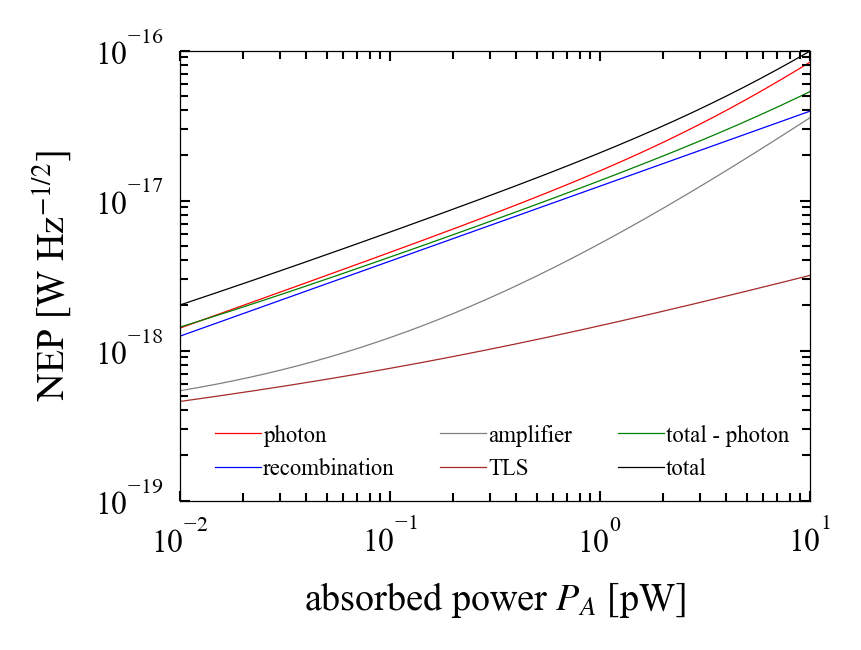

In [12]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('NEP [W Hz$^{-1/2}$]')

ax.plot(P_A_scale * P_A,
        photon**(1/2),
        color=photon_color, label='photon')

ax.plot(P_A_scale * P_A,
        recombination**(1/2),
        color=recombination_color, label='recombination')

ax.plot(P_A_scale * P_A,
        amplifier**(1/2),
        color=amp_color, label='amplifier')

ax.plot(P_A_scale * P_A,
        TLS**(1/2),
        color=TLS_color, label='TLS')

ax.plot(P_A_scale * P_A,
        nonphoton**(1/2),
        color=nonphoton_color, label='total - photon')

ax.plot(P_A_scale * P_A,
        total**(1/2),
        color=total_color, label='total')

ax.legend(loc='lower right', fontsize=5.5, ncol=3);

#fig.savefig('/Users/daniel/Desktop/NEP_vs_P_A.pdf', bbox_inches='tight');

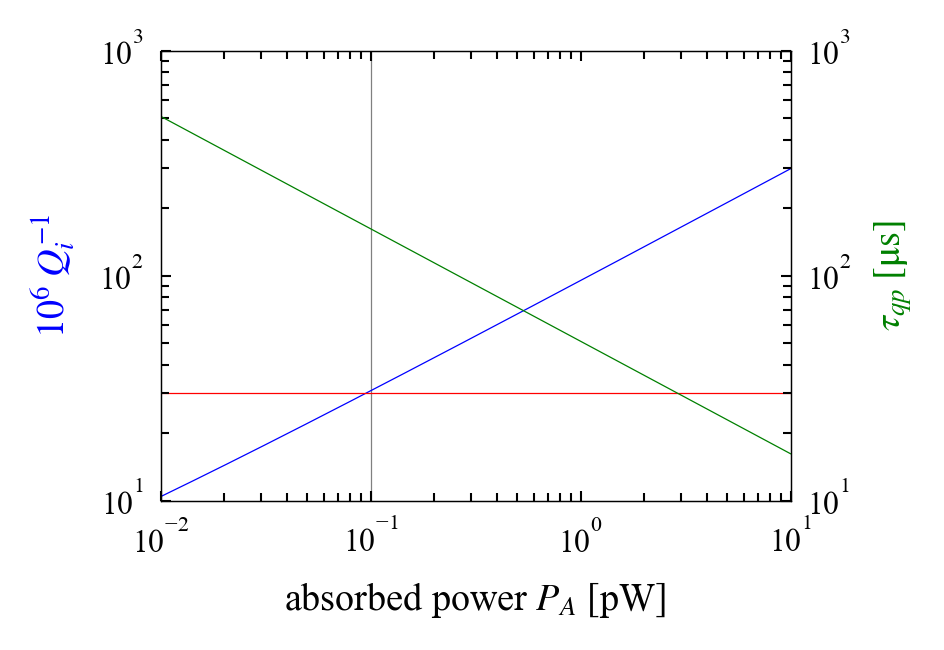

In [13]:
iQi_color = 'blue'
tau_qp_color = 'green'

fig, iQi_ax = plt.subplots()
tau_qp_ax = iQi_ax.twinx()

iQi_ax.set_xscale('log')
iQi_ax.set_yscale('log')
tau_qp_ax.set_yscale('log')
iQi_ax.set_xlabel('absorbed power $P_A$ [pW]')
iQi_ax.set_ylabel('$10^6 \; Q_i^{-1}$', color=iQi_color)
tau_qp_ax.set_ylabel(r'$\tau_{qp} \; [\mathrm{\mu s}]$', color=tau_qp_color)

iQi_ax.axvline(0.1, color='gray')

iQi_ax.plot(P_A_scale * P_A,
            1e6 * (iQqp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, Gamma=Gamma, alpha=alpha) + iQi0),
            color=iQi_color)

tau_qp_ax.plot(P_A_scale * P_A,
               1e6 * tau_qp(Gamma=Gamma, V_um3=V_um3),
               color=tau_qp_color)

iQi_ax.axhline(1e6 * iQc, color='red');

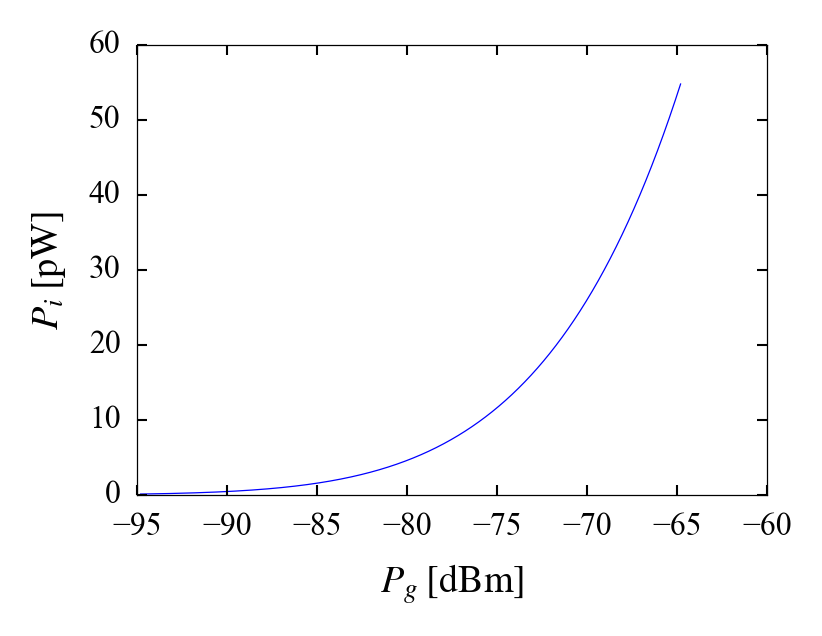

In [14]:
fig, ax = plt.subplots()
one_mW = 1e-3
ax.plot(10 * np.log10(P_g / one_mW), 1e12 * chi_a(iQi=iQi, iQc=iQc) * P_g)
ax.set_xlabel(r'$P_g \; [\mathrm{dBm}]$')
ax.set_ylabel(r'$P_i \; [\mathrm{pW}]$');

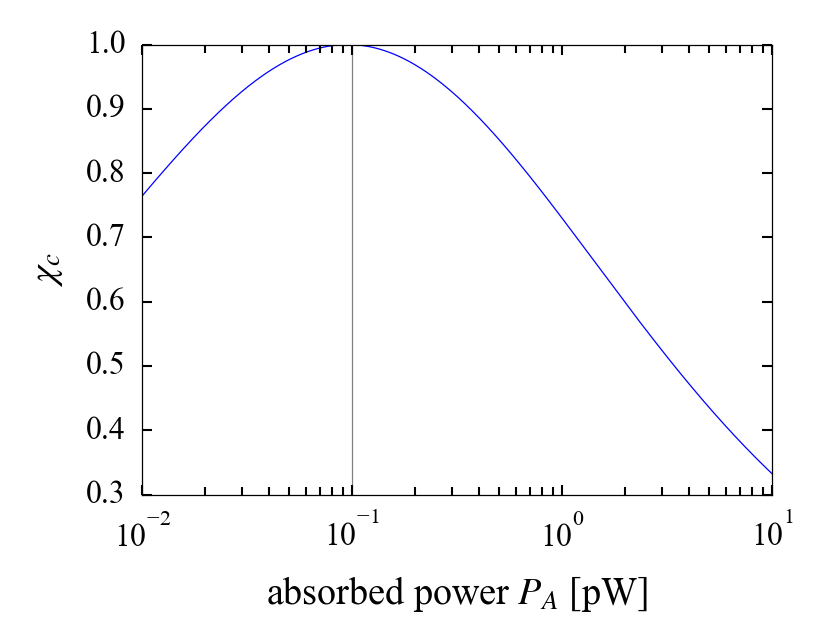

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('$\chi_c$')

ax.semilogx(P_A_scale * P_A,
        chi_c(iQi=iQqp(f=f_r, T=T_bath, T_c=T_c, V_um3=V_um3, Gamma=Gamma, alpha=alpha) + iQi0, iQc=iQc))
ax.axvline(0.1, color='gray');

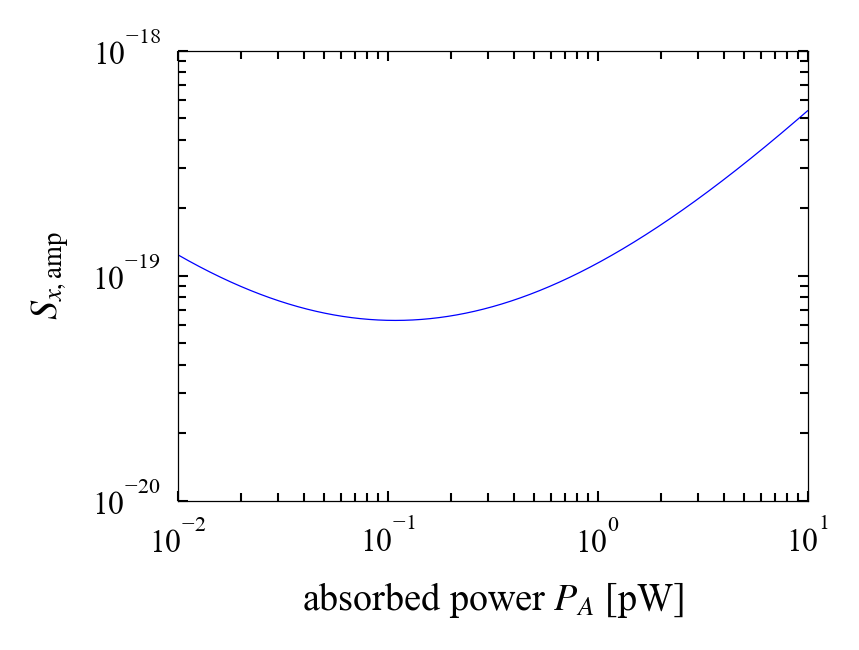

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('$S_{x, \mathrm{amp}}$')
ax.loglog(P_A_scale * P_A,
        (k_B * T_amp / P_g) / np.abs(d_S21_d_x(iQi=iQi, iQc=iQc))**2)

# Amplifier NEP sanity check

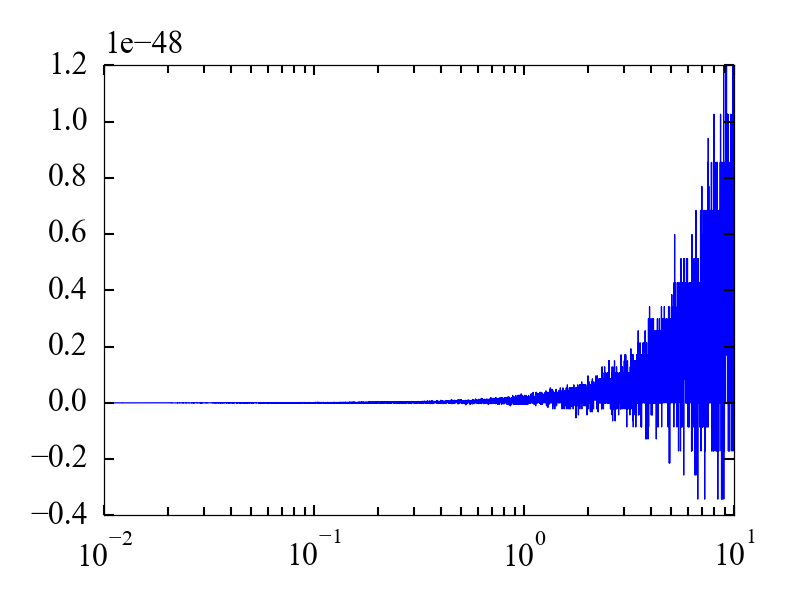

In [17]:
beta = S_2(f=f_r, T=T_bath, T_c=T_c) / S_1(f=f_r, T=T_bath, T_c=T_c)
Delta = BCS * k_B * T_c
eta_pb = pair_breaking_efficiency(nu=np.array([nu_center]), T_c=T_c)[0]
chi_qp = (iQi - iQi0) / iQi
P_a_Jonas = chi_c(iQi=iQi, iQc=iQc) * P_g / 2
NEP2_amplifier_Jonas = ((8 * N_qp(Gamma=Gamma, V_um3=V_um3)**2 * Delta**2 * k_B * T_amp) /
                        (beta**2 * eta_pb**2 * chi_c(iQi=iQi, iQc=iQc) * chi_qp**2 * tau_qp(Gamma, V_um3)**2 * P_a_Jonas))

fig, ax = plt.subplots()
ax.semilogx(P_A_scale * P_A,
        NEP2_amplifier_Jonas - amplifier)


In [18]:
beta

2.7744080667063846

In [19]:
f_r_skip = 100e6
T_c_skip = 1.39
beta_skip = S_2(f=f_r_skip, T=T_bath, T_c=T_c_skip) / S_1(f=f_r_skip, T=T_bath, T_c=T_c_skip)
beta_skip


20.927331189872969

# Photon NEP sanity check

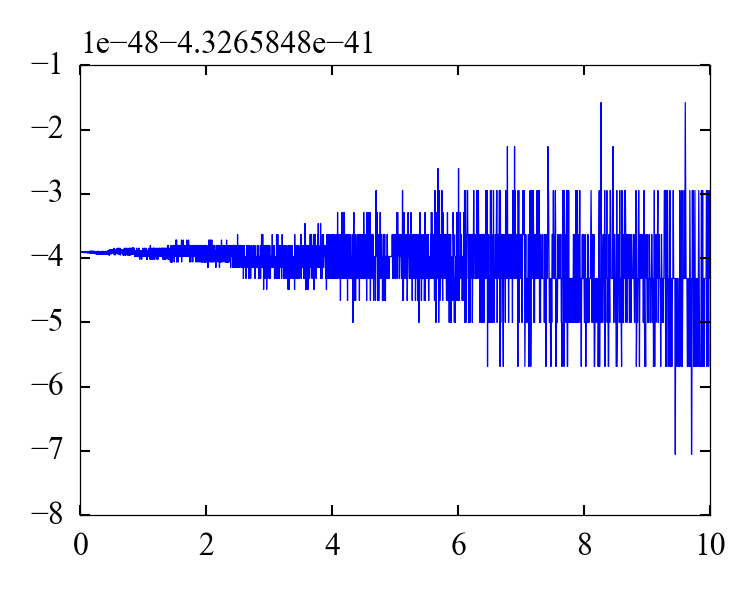

In [20]:
fig, ax = plt.subplots()
ax.plot(P_A_scale * P_A,
        photon - NEP2_photon_simple(P_A=P_A, P_B=P_B, nu=nu_center, bandwidth=bandwidth))


# Generation efficiency

In [21]:
nu = np.linspace(0, 4 * gap_frequency(T_c), 1e3)
nu = nu[1:]

In [22]:
eta_color = 'blue'
m_color = 'green'

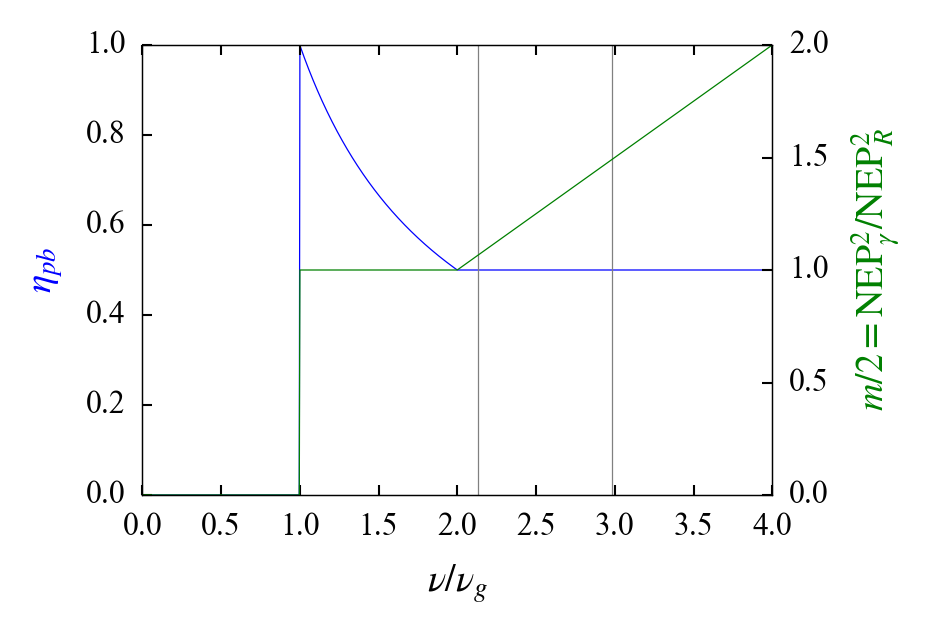

In [23]:
fig, eta_ax = plt.subplots()
m_ax = eta_ax.twinx()

eta_ax.plot(nu / gap_frequency(T_c), pair_breaking_efficiency(nu, T_c),
            color=eta_color)
eta_ax.set_xlabel(r'$\nu / \nu_g$')
eta_ax.set_ylabel(r'$\eta_{pb}$', color=eta_color)
m_ax.plot(nu / gap_frequency(T_c), quasiparticles_per_photon(nu, T_c) / 2,
          color=m_color)
m_ax.set_ylabel('$m / 2 = \mathrm{NEP}_\gamma^2 / \mathrm{NEP}_R^2$',
                color=m_color)

eta_ax.axvline(125e9 / gap_frequency(T_c), color='gray')
eta_ax.axvline(175e9 / gap_frequency(T_c), color='gray')

#fig.savefig('/Users/daniel/Desktop/eta_pb_and_m_vs_frequency.pdf', bbox_inches='tight')

# $S_1$ and $S_2$

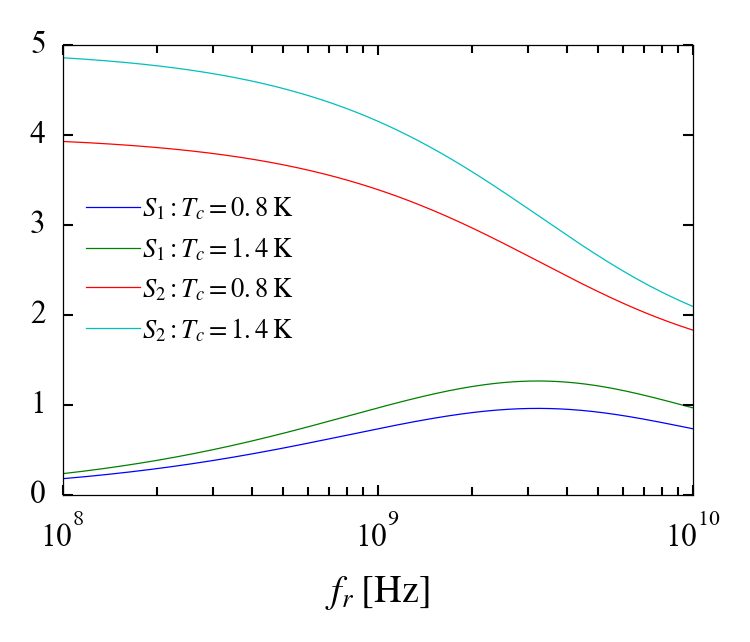

In [24]:
T_c_skip = 1.39

ff = np.logspace(8, 10, 1e3)

fig, ax = plt.subplots()
ax.semilogx(ff, S_1(f=ff, T=T_bath, T_c=T_c), label='$S_1: T_c = 0.8 \; \mathrm{K}$')
ax.semilogx(ff, S_1(f=ff, T=T_bath, T_c=T_c_skip), label='$S_1: T_c = 1.4 \; \mathrm{K}$')
ax.semilogx(ff, S_2(f=ff, T=T_bath, T_c=T_c), label='$S_2: T_c = 0.8 \; \mathrm{K}$')
ax.semilogx(ff, S_2(f=ff, T=T_bath, T_c=T_c_skip), label='$S_2: T_c = 1.4 \; \mathrm{K}$')
ax.set_xlabel('$f_r \; [\mathrm{Hz}]$')
ax.legend(loc='best', fontsize='xx-small');

# Classes

In [25]:
class Resonator(object):
    
    def __init__(self, active, active_volume, alpha):
        self.active = active
        self.active_volume = active_volume
        self.alpha = alpha

def Superconductor(object):
    
    def __init__(self, T_c, N0):
        self.T_c = T_c
        self.N0 = N0